In [58]:
import numpy as np
import pandas as pd
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

In [68]:
color_list = [i for i in mcolors.TABLEAU_COLORS]
marker_list = ["o", "x"]

In [2]:
def time_converter(data, minute=False):
    x = data.split('-')
    if len(x)==1:
        d = 0
        x = x[0]
    else:
        d = int(x[0])
        x = x[1]
    h,m,s = map(int,x.split(':'))
    if minute == True:
        return (d*24 + h)*60 + m + s/60
    return (((d*24 + h)*60+m)*60+s)/60

In [3]:
def memory_size_converter(size):
    giga = True
    if 'M' in size:
        giga = False
    num = float(size.rstrip('MnG'))
    if giga:
        return num*1024
    return num

# Read XNAT log

- Requested memory in MB
- Requested walltime in min

In [4]:
df = pd.read_excel('xnat_accre_full_stats.xlsx')

In [5]:
df['Timelimit_num'] = df['Timelimit'].astype(str)
df['Timelimit_num'] = df.Timelimit_num.apply(time_converter)

In [17]:
df['Walltime_num'] = df['Elapsed'].astype(str)
df['Walltime_num'] = df.Walltime_num.apply(time_converter)

In [6]:
df['ReqMem_num'] = df.ReqMem.apply(memory_size_converter)
df = df[df['memused'].notnull()].copy()
df['memused'] = df['memused'].astype(str)
df = df[df.memused.apply(lambda x: x.isnumeric())]
df['memused'] =  pd.to_numeric(df['memused']) / 1024

In [16]:
df.columns

Index(['jobstartdate', 'jobSubmitDate', 'id', 'proctype', 'memused',
       'input(MB)', 'output(MB)', 'walltime(min)', 'JobID', 'Submit',
       'Eligible', 'Start', 'End', 'Elapsed', 'ExitCode', 'State', 'NNodes',
       'NCPUS', 'ReqCPUS', 'ReqMem', 'ReqGRES', 'ReqTRES', 'Timelimit',
       'NodeList', 'Timelimit_num', 'ReqMem_num'],
      dtype='object')

In [22]:
df.State.unique()

array(['COMPLETED', 'FAILED', 'CANCELLED by 0', 'TIMEOUT'], dtype=object)

In [25]:
df.groupby("State")["id"].count()

State
CANCELLED by 0        1
COMPLETED         20763
FAILED               13
TIMEOUT               1
Name: id, dtype: int64

In [23]:
df[df["Walltime_num"] > df["Timelimit_num"]].head()

,jobstartdate,jobSubmitDate,id,proctype,memused,input(MB),output(MB),walltime(min),JobID,Submit,...,NCPUS,ReqCPUS,ReqMem,ReqGRES,ReqTRES,Timelimit,NodeList,Timelimit_num,ReqMem_num,Walltime_num
19972,2018-06-11,2018-05-23,VUIISXNAT04_E56097,fMRIQA_v2,1919.625,51.0,0.790039,37.283333,27885396,2018-06-12T03:07:54,...,1,1,4Gn,NaN,"cpu=1,mem=4G,node=1",00:30:00,vmp1389,30.0,4096.0,33.016667


In [28]:
df[df["memused"] >= df["ReqMem_num"]].head()

,jobstartdate,jobSubmitDate,id,proctype,memused,input(MB),output(MB),walltime(min),JobID,Submit,...,NCPUS,ReqCPUS,ReqMem,ReqGRES,ReqTRES,Timelimit,NodeList,Timelimit_num,ReqMem_num,Walltime_num
19696,2018-05-24,2018-05-24,VUIISXNAT04_E56855,AbOrganSeg_Whole_v1,10287.371094,42.0,0.625,7.066667,27499851,2018-05-24T18:08:44,...,2,2,10Gn,NaN,"cpu=2,mem=10G,node=1",2-12:00:00,vmp1011,3600.0,10240.0,3.516667


# Get submission profiles for all application in the xnat log

In [66]:
# eliminate the failed cases
df = df[df.State != "FAILED"]

In [13]:
multi_submission_apps = []
application_list = df["proctype"].unique()
for app in application_list:
    df_resource = df[df.proctype == app][["ReqMem_num", "Timelimit_num"]].drop_duplicates()
    if len(df_resource) > 1:
        multi_submission_apps.append(app)

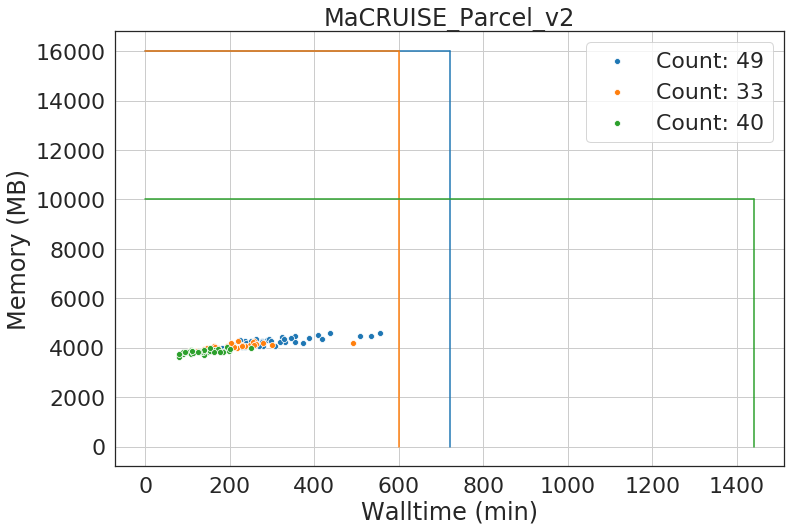

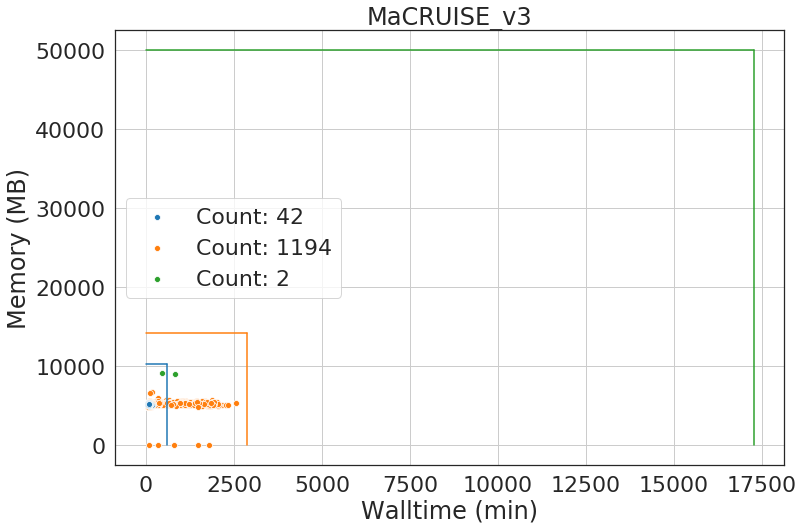

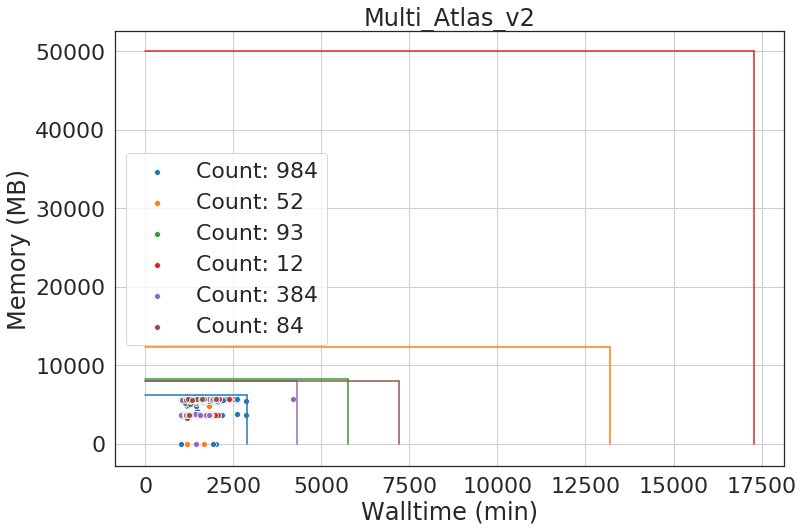

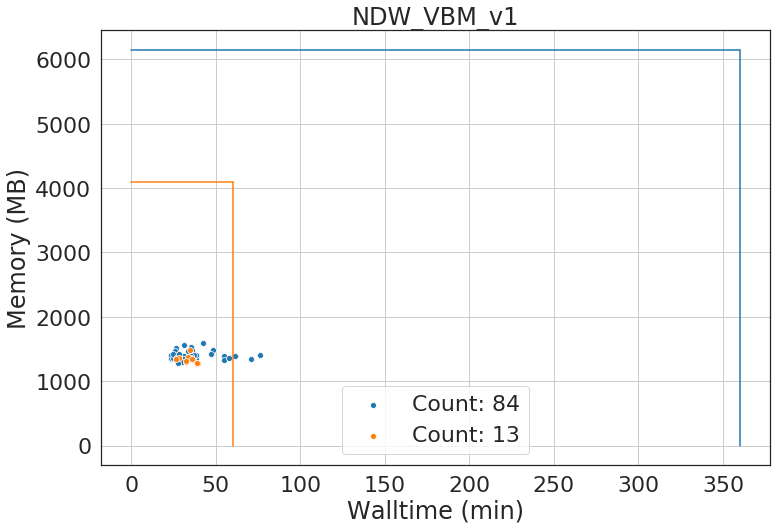

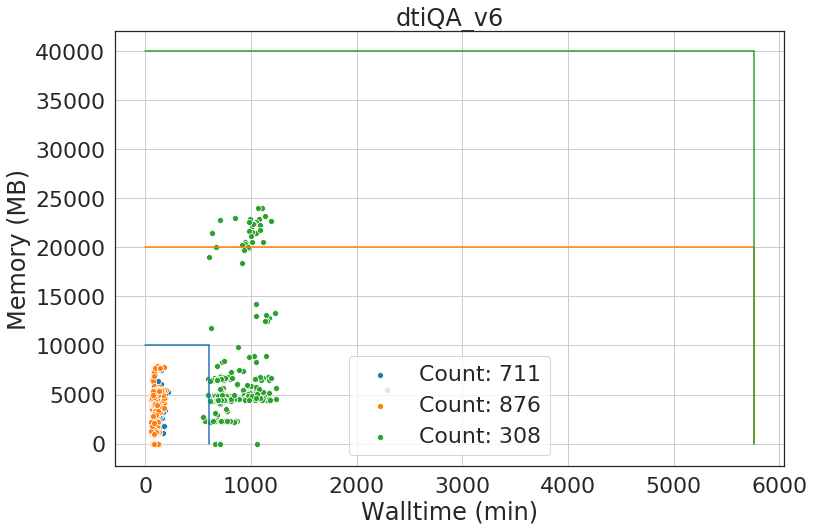

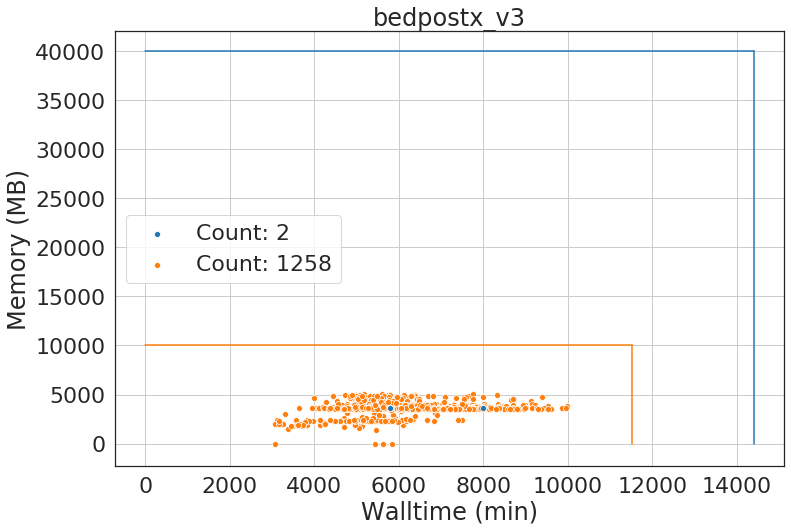

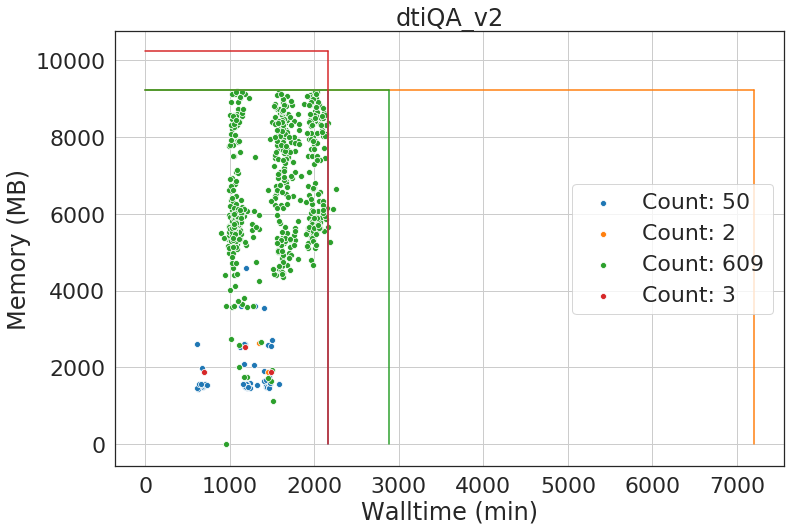

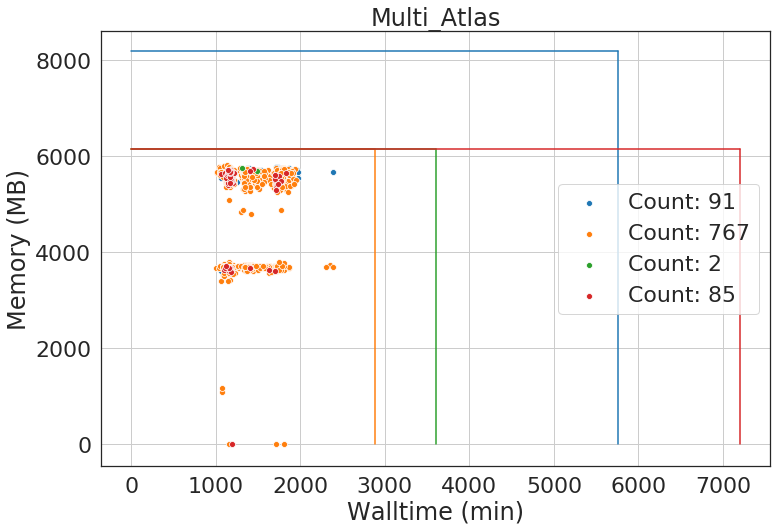

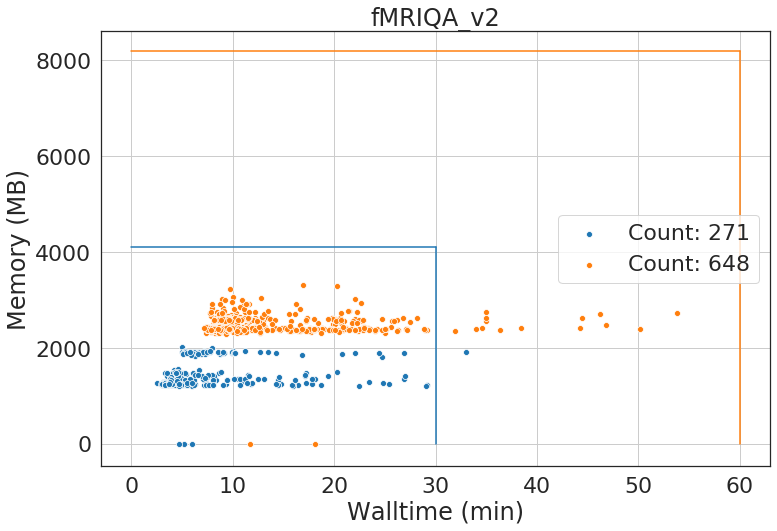

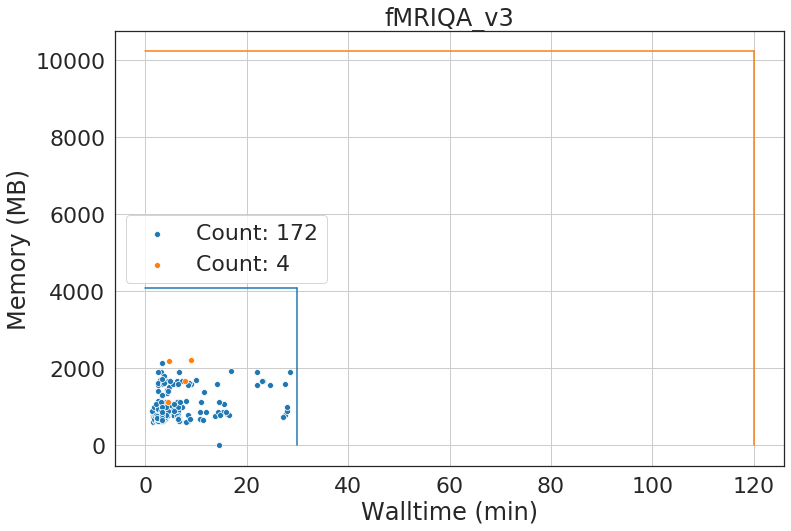

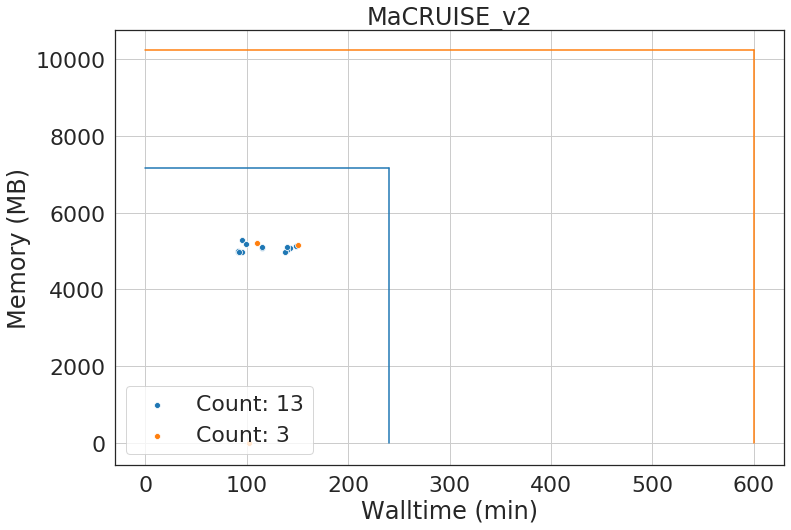

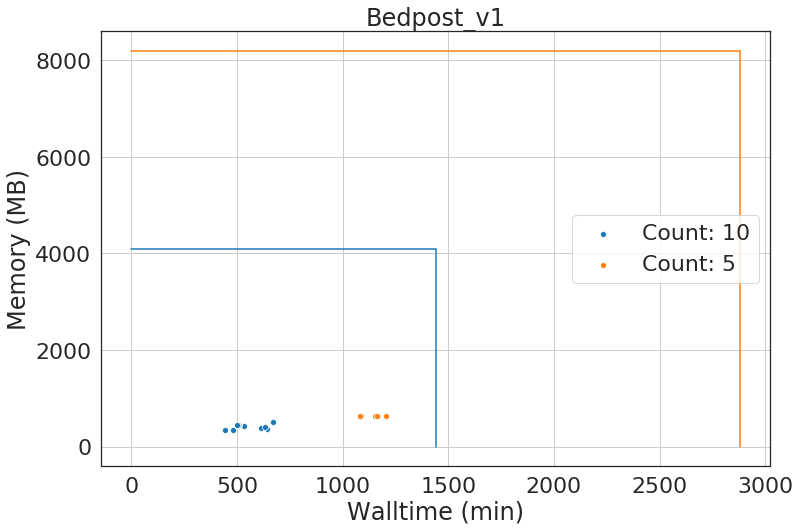

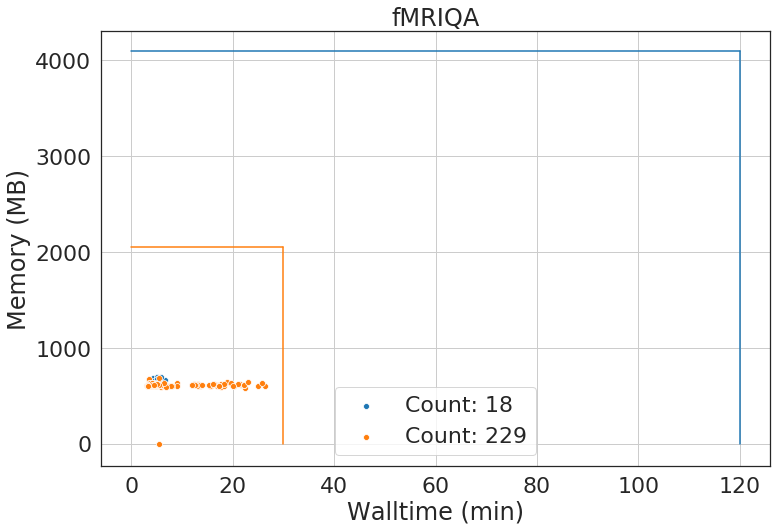

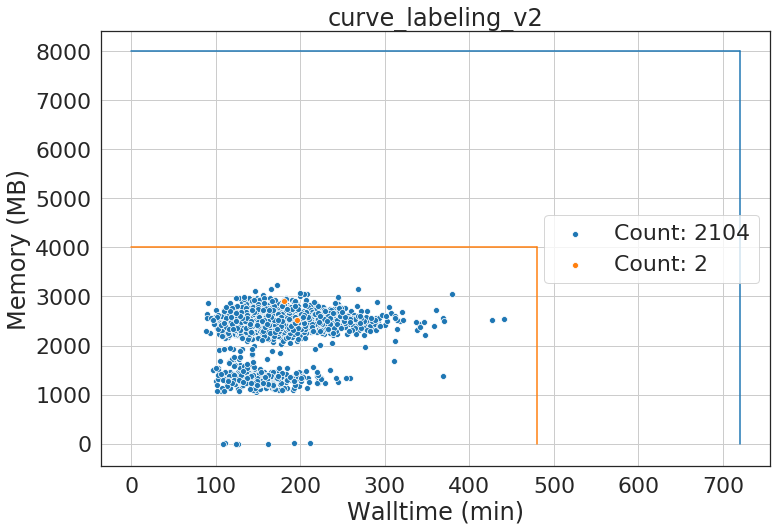

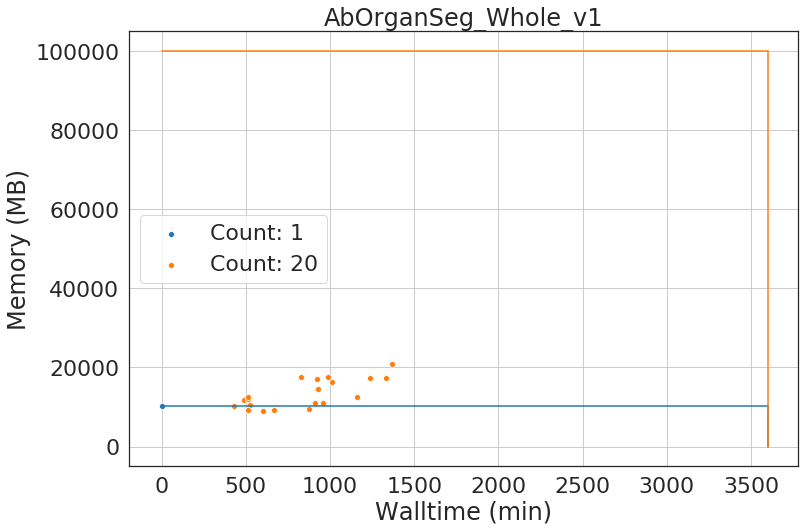

In [73]:
for dataset in multi_submission_apps:
    request = df[df.proctype == dataset][["ReqMem_num", "Timelimit_num"]].drop_duplicates()
    dfset = df[df.proctype == dataset]

    fig, ax = plt.subplots(figsize=(12,8))
    sns.set(font_scale=2)
    sns.set_style("white")

    # set the request times
    cnt = 0
    for i in request.values:
        # time in database is in min
        plt.plot([i[1], i[1]], [0, i[0]], color=color_list[cnt])
        plt.plot([0, i[1]], [i[0], i[0]], color=color_list[cnt])
        ax = sns.scatterplot(y="memused", x="Walltime_num", #marker=marker_list[cnt % 2],
                             data=dfset[(dfset.Timelimit_num == i[1]) & (dfset.ReqMem_num == i[0])],
                             color = color_list[cnt], label="Count: %d" %(
                                 len(dfset[(dfset.Timelimit_num == i[1]) & (dfset.ReqMem_num == i[0])])))
        cnt += 1

    plt.grid(True)
    if dataset == "MaCRUISE_v3" or dataset == "bedpostx_v3":
        #ax.set_xscale('log', basex=2)
        #ax.set_yscale('log', basey=2)
        ax = sns.scatterplot(y="memused", x="Walltime_num", 
                             data=dfset[(dfset.Timelimit_num == request.values[0][1]) & (dfset.ReqMem_num == request.values[0][0])],
                             color = color_list[0])
    ax.set_xlabel('Walltime (min)')
    ax.set_ylabel('Memory (MB)')
    ax.set_title(dataset)

    plt.savefig("figures/%s.png" %(dataset))
    plt.show()